# Numerical exercise QM

### Thorvald M. Ballestad | Knut Andre G. Prestsveen

## Intro

In this notebook we numerically integrate the time dependent schrödinger equation, and study the following aspects of quantum mechanics:
<ul>
    <li>Propagation of wave packets</li>
    <li>Scattering by a barrier</li>
    <li>Tunneling</li>
</ul>

### Theory and numerical method

We restric the study to one dimension, and the wave packet is represented by a plane wave, multiplied with a Gaussian function:

*eqn 8*

Here x is the particles position (xs being the initial position), t is the time and C is a normalization constant. *sigma_x* is the standard deviation of the Gaussian, *omega* the wave functions angular velocity, and *k0* its wave number. From QM-theory we have the following relations for *omega* and the energy *E*:

*Omega, energy*

The schrödinger equation reads:

*TDSE*

To solve it numerically we discretezie the time and position, and by sepparating (TDSE) into a real and imaginary part, and approximatng the derivatives using central finite differences, we arrive at the following recursive formulas for the wave function:

*rec im re*

And solvning these iteratively gives us the time development of the wave packet. The full derivation of the expressions (1,2), as well as a description of the numerical implementation is found in *oppgaven*.

### Numerical stability

To ensure numerical stability using this method we chose need to chose the time step *delta t* sufficiently small. More precisely we need 

(12)

As derived in *oppgave*


## Implementation

We start by importing necessary packages and setting some sensible figure parameters.

In [1]:
'''Import necessary packages'''
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

In [2]:
'''Set common figure parameters:'''
newparams = {'axes.labelsize': 11, 'axes.linewidth': 1, 'savefig.dpi': 100, 
             'lines.linewidth': 1.0, 'figure.figsize': (10, 8),
             'ytick.labelsize': 10, 'xtick.labelsize': 10,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,}
plt.rcParams.update(newparams)

Then we set the physical properties of the system and parameters for the simulation.

In [3]:
'''Parameters and constants'''
h_bar = 1 # For the simulation we set Placks reduced constant to one.
m = 1 # particles mass
k_0 = 20 # wave number of the initial wave function
L = 20 # Length of the system
N = 1000 # spacial resolution of the system
omega = h_bar * k_0**2 / (2*m) # eqn. ??
E = h_bar * omega # eqn. ??
dx = L/(N-1) # delta x

x_s = 5 # Start position
x_f = L/2 + x_s # final position, later we will let the wave propagate til it reaches here, ellerno
sigma_x = 1.5 # initial standard deviation

x = np.linspace(0, L, N) # Spacing should be almost dx

v = np.zeros(N) # Zero potential
dt = 0.1 * h_bar / (h_bar**2 /(2*m*dx**2) + np.max(v)) # Timestep, much smaller than ..., see (12)

'''Parameters for propagation'''
v_g = h_bar*k_0/m # group velocity
sim_time = L/(2*v_g) # simulation time
num_iter = int(sim_time/dt) # number of iterations

And finally we implement functions carrying out the simualtion and plotting.

In [4]:
def timestep(psi_im, psi_re, v, dt):
    """Performs one timestep of size dt
    Input:
        psi_im : Psi_im(x, t)
        psi_re : Psi_re(x, t + dt/2)
    Returns:
        psi_im : Psi_im(x, t + dt)
        psi_re : Psi_re(x, t + dt)
    """
    
    assert psi_im[0] == psi_im[-1] == psi_re[0] == psi_re[-1] == 0, "Psi should be zero for x = 0 and x = L"
    # Find psi_im(t+dt) given psi_im(t) and psi_re(t + dt/2)
    psi_im[1:-1] -= dt*(v[1:-1]*psi_re[1:-1]/h_bar - (psi_re[2:] - 2*psi_re[1:-1] + psi_re[:-2])*h_bar/(2*m*dx**2))
    
    # Find psi_re(t+ 3*dt/2) given psi_re(t+dt/2) and psi_im(t+dt) (remember, psi_im is now at t = t+dt)
    psi_re[1:-1] += dt*(v[1:-1]*psi_im[1:-1]/h_bar - (psi_im[2:] - 2*psi_im[1:-1] + psi_im[:-2])*h_bar/(2*m*dx**2))
    
    return psi_im, psi_re

In [5]:
def generate_psi(x_s=x_s, sigma_x=sigma_x, num_iter=num_iter, N=N):
    """Generates inital values for psi
    Returns:
        psi_re
        psi_im"""
    # Arrays for storing psis at different points in time, need this later
    psi_re = np.zeros([num_iter, N])
    psi_im = np.zeros([num_iter, N])
    
    # Normalization
    C = 1/np.sqrt(
        np.sum(np.exp(-(x-x_s)**2/(sigma_x**2)))*dx
    )

    # see (8)
    psi_re[0, 1:-1] = C*np.exp(-(x[1:-1]-x_s)**2/(2*sigma_x**2)) * np.cos(k_0*x[1:-1] - omega*dt/2)
    psi_im[0, 1:-1] = C*np.exp(-(x[1:-1]-x_s)**2/(2*sigma_x**2)) * np.sin(k_0*x[1:-1])
    return psi_re, psi_im

In [6]:
# Yo, Knært, jeg orket ikke tenke på hvor man burde plassere ting, så la den her. Kanskje dust, men den må hvertfall være før generate_psi()
''' Problem 1'''



' Problem 1'

In [7]:
def generate_barrier(barrier_width, barrier_strength):
    return barrier_strength * np.heaviside(x*np.heaviside(-x +L/2 +barrier_width/2, 1) -L/2+barrier_width/2, 0)

In [8]:
def simulate(x_s, sigma_x, barrier_width, barrier_strength, num_iter):
    '''
    Runs simulation for num_iter timesteps, using the timestep function.
    
    Input:
        v: potential vector
        x_s: starting position
        sigma_x: standard deviation for the Gaussian
        num_iter: number of interations (timesteps)
    Output:
        psi_real: vector with the real parts of the WF at each timestep
        psi_imag: vector with the imaginary parts of the WF at each timestep
    '''
    C = 1/np.sqrt(
    np.sum(np.exp(-(x-x_s)**2/(sigma_x**2)))*dx
    )
    
    v = generate_barrier(barrier_width, barrier_strength)
    psi_re, psi_im = generate_psi(x_s=x_s, sigma_x=sigma_x, num_iter=num_iter)

    for i in range(num_iter-1):
        psi_im[i+1], psi_re[i+1] = timestep(psi_im[i], psi_re[i], v, dt) #todo: pass more sensible dt
        
    return psi_re, psi_im

In [9]:
def simulate_and_plot(x_s, sigma_x, barrier_width, barrier_strength, num_iter):
    """Simulates and plots inital and final state for psi_re"""
    psi_re, _ = simulate(x_s, sigma_x, barrier_width, barrier_strength, num_iter)
    plt.plot(x, psi_re[0], label="Initial Re")
    plt.plot(x, psi_re[-1], label="Final Re")
    plt.legend()

In [10]:
def simulate_and_plot_with_pd(x_s, sigma_x, barrier_width, barrier_strength, num_iter):
    """Simulates and plots inital and final state for psi_re, 
    as well as initial and final probability density"""
    psi_re, psi_im = simulate(x_s, sigma_x, barrier_width, barrier_strength, num_iter)
    initial_prob_density = np.square(np.absolute(psi_re[0] + psi_im[0]*1j))
    final_prob_density = np.square(np.absolute(psi_re[-1] + psi_im[-1]*1j))
    plt.plot(x, psi_re[0], label="Initial Re")
    plt.plot(x, psi_re[-1], label="Final Re")
    plt.legend()
    plt.show()
    plt.plot(x, initial_prob_density, label="initial probability density")
    plt.plot(x, final_prob_density, label="final probability density")
    plt.legend()
    plt.show()

In [11]:
# Helper function for animation

def _get_ims_3D(psi_1, psi_2, ax):
    ims = []
    for i in range(0, len(psi_1), 100):
        ln1 = plt.plot(x, psi_1[i], psi_2[i], 'tab:blue')
        ims.append(ln1)
    return ims

def _get_ims_2D(psi_1, psi_2, ax):
    ims = []
    for i in range(0, len(psi_1), 100):
        ln1, = ax.plot(x, psi_1[i], 'tab:orange')
        ln2, = ax.plot(x, psi_2[i], 'tab:blue')
        ims.append((ln1, ln2,))
    return ims

In [12]:
def animate(psi_1, psi_2, in_3D=False):
    """Animates psi_1 and psi_2
    Parameters:
        psi_1, psi_2 : ndarray, shape (num_iterations, N)
        in_3D        : bool, animate in 3D
    Returns:
        HTML5 video"""
    assert len(psi_1)==len(psi_2), "psi_1 and psi_2 must have the same length!"
    fig = plt.figure(figsize=(8, 6))
    if in_3D:
        ax = fig.add_subplot('111', projection='3d')
        ims = _get_ims_3D(psi_1, psi_2, ax)
    else:
        ax = fig.add_subplot('111')
        ims = _get_ims_2D(psi_1, psi_2, ax)
        
    anim = animation.ArtistAnimation(fig, ims, interval=60)
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

def simulate_and_animate(x_s, sigma_x, barrier_width, barrier_strength, num_iter, in_3D=False):
    psi_re, psi_im = simulate(x_s, sigma_x, barrier_width, barrier_strength, num_iter)
    
    return animate(psi_re, psi_im, in_3D=in_3D)

## The initial state of the wave packet

We start by calculating the initial wave function, normalising it, and plotting the real and imaginary parts. We also plot the initial probability distribution for the particles position given by $\mid{\Psi(x,t)}\mid^2$.

In [13]:
psi_re, psi_im = generate_psi()

Simulated time: 0.4999594188783378s


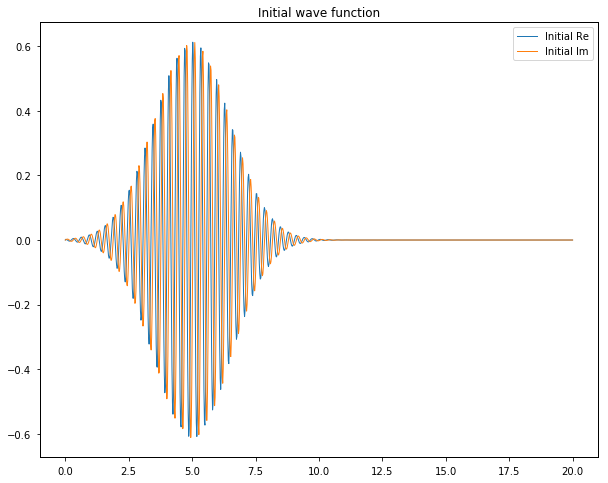

In [14]:
''' Plot start state, real and imaginary'''
plt.plot(x, psi_re[0], label="Initial Re")
plt.plot(x, psi_im[0], label="Initial Im")
plt.title('Initial wave function')
plt.legend()
simulated_time = dt*num_iter
print(f"Simulated time: {simulated_time}s")

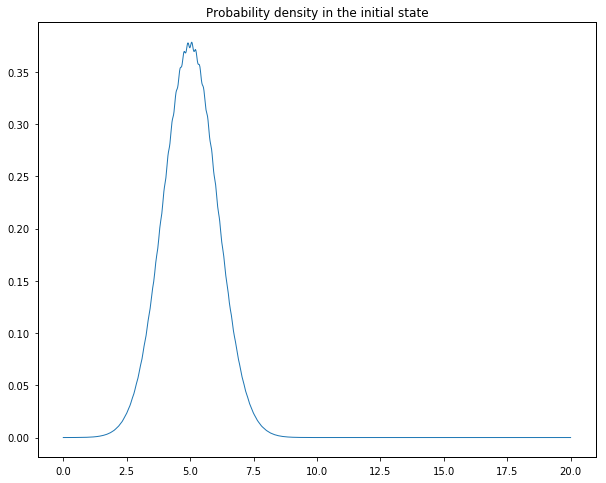

In [15]:
'''Initial probability density'''
initial_prob_density = np.square(np.absolute(psi_re[0] + psi_im[0]*1j))
plt.plot(x, initial_prob_density, label='')
plt.title('Probability density in the initial state')
plt.show()

## Propagation in the zero potential

We now let the wave packet propagate from its starting position $x_s = 5$ to $x_f = 15$, and plot the real parts of the initial and final wave functions.

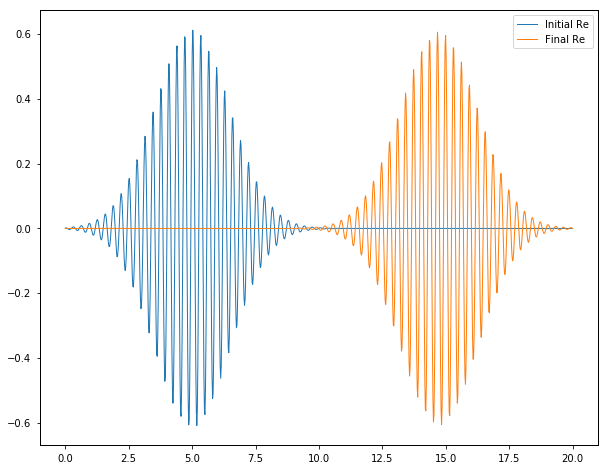

In [16]:
simulate_and_plot(x_s, sigma_x, 0, 0, num_iter)

Now we run the same simulation again, but with different values for the initial standard deviation *\sigma_x*. We see from the plots below that the wave function spreads out as time elapses, and it is more apparent for smaller initial spread.

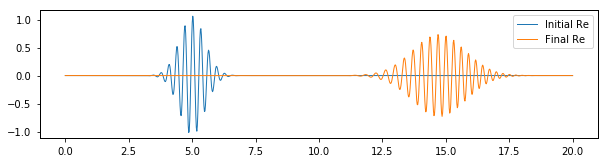

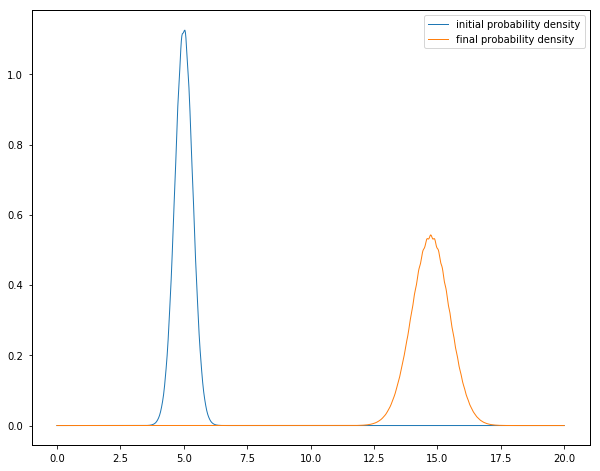

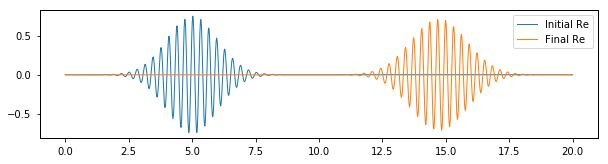

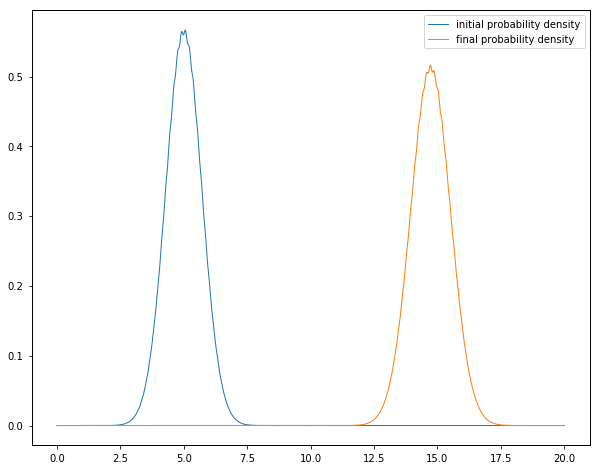

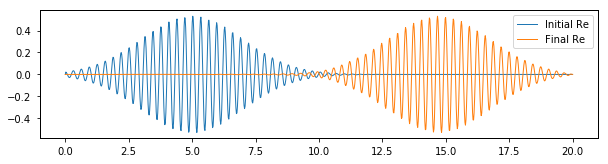

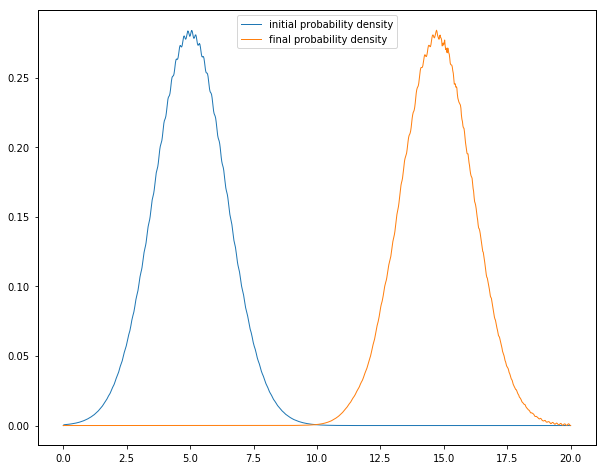

In [17]:
'''Simulation for more sigma_x's'''
sigma_xs = [0.5, 1.0, 2.0]

for i, sigma_x in enumerate(sigma_xs):
    plt.subplot(f"31{i+1}")
    simulate_and_plot_with_pd(x_s, sigma_x, 0, 0, num_iter)

## Propagation through a barrier

Now we place a barrier inside the system in order to study transmission and tunneling.

In [18]:
'''Defines a barrier'''
l = L/20 # barrier width
v_0 =  3*E/4 # barrier height
psi_re, psi_im = simulate(x_s, sigma_x, l, v_0, num_iter)

Running the simulation now, letting the wave packet propagate through the barrier, shows that the wave function get partially transmitted and partially reflected.

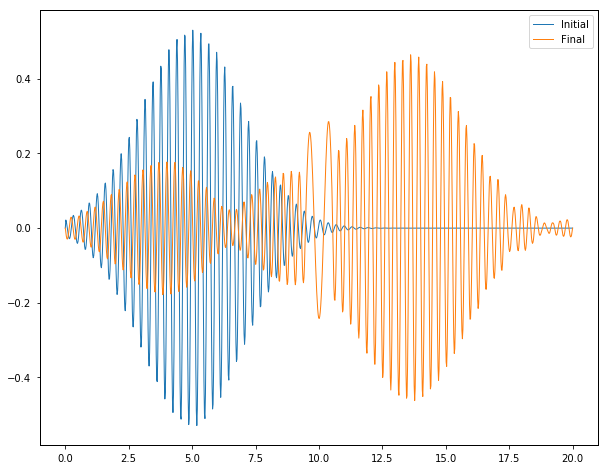

In [19]:
'''Plot start and final state'''
plt.plot(x, psi_re[0], label="Initial")
plt.plot(x, psi_re[-1], label="Final")
plt.legend()

In [20]:
'''Animation'''
animate(psi_re, psi_im)

The probabilites of transmission and reflection for this barrier is:

In [21]:
'''Calculates P(right) and P(left), probability of being right and left of the barrier'''
mid_i = int(N/2) # Index of center

P_right = np.sum((psi_re**2+psi_im**2)[[0, -1], mid_i:], axis=1)*dx
P_left = np.sum((psi_re**2+psi_im**2)[[0, -1], :mid_i], axis=1)*dx

#print(f"P_right: {P_right}\nP_left: {P_left}\nSum: {P_right + P_left}")

print(f"Probability of transmission: {P_right[1]}")
print(f"Probability of reflection: {P_left[1]}")

Probability of transmission: 0.8358414202352459
Probability of reflection: 0.16375308705553043


## Transmission and reflection probability as function of barrier height and width

Finally we calculate the transmission and reflection probabilities for a range of different barrier widths and heights, and plot the result.

In [22]:
'''Calculates transmission probability as a function of barrier height'''
l = L/40
fraction = np.linspace(0, 3/2, 50)
P_trans = []

for f in fraction:
    psi_re, psi_im = simulate(x_s, sigma_x, l, f*E, num_iter)
    P_trans.append(np.sum((psi_re**2+psi_im**2)[-1, mid_i:])*dx)

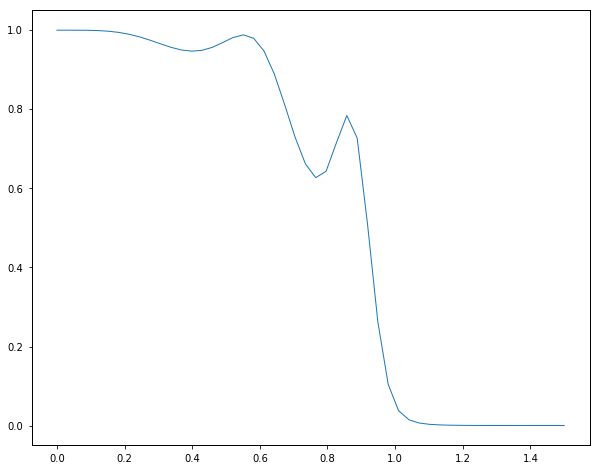

In [23]:
plt.plot(fraction, P_trans)

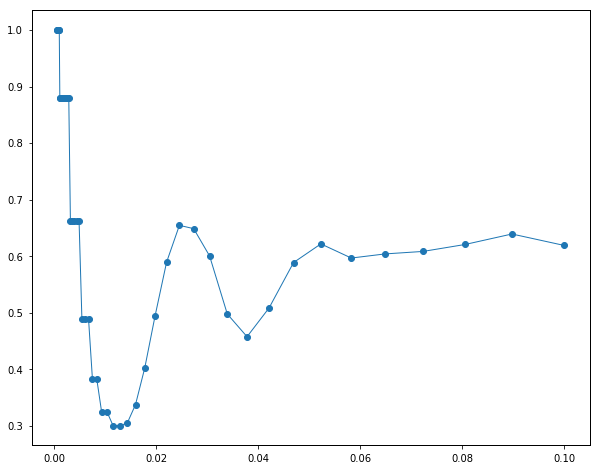

In [24]:
# Find transmission probability as a function of barrier width
v_0 =  9*E/10 # barrier height

widths = np.geomspace(0.01, L/10, 50)
P_trans = []

for l in widths:
    psi_re, psi_im = simulate(x_s, sigma_x, l, v_0, num_iter)
    P_trans.append(np.sum((psi_re**2+psi_im**2)[-1, mid_i:])*dx)
plt.plot(widths/L, P_trans, 'o-') # Note that widths are plotted as fractions of L
plt.show()